In [16]:
import os
import tensorflow as tf
print("TensorFlow version: ", tf.__version__)
gpu = tf.config.experimental.list_physical_devices('GPU')
print("GPUs Available: ", len(gpu))
tf.config.experimental.set_memory_growth(gpu[0], True)
import numpy as np
import cv2
from PIL import Image
import pandas as pd
from sklearn.metrics import confusion_matrix
from keras.models import Model
from keras import layers
from keras.utils.layer_utils import get_source_inputs
from sklearn.svm import SVC
from keras.applications import ResNet50
from matplotlib import pyplot as plt
import mtcnn
print(mtcnn.__version__)
from matplotlib import pyplot as plt
import shutil

TensorFlow version:  2.9.3
GPUs Available:  1
0.1.0


## 10000 imgs
5000 homens 5000 mulheres split 50% para teste e treino


In [2]:
np.random.seed(255)
df = pd.read_csv('.\FACES\FileAttr2.txt', delimiter=' ')
print(df.columns)
mulher = df.loc[df['Male'] == -1, 'file'].tolist() # todos indices de linhas com imagens de mulhers
homem = df.loc[df['Male'] == 1, 'file'].tolist() # todos indices de linhas com imagens de homens
mulher_train = mulher[:2500]
mulher_test = mulher[2500:5000]
homem_train = homem[:2500]
homem_test = homem[2500:5000]
np.random.shuffle(mulher_train)
np.random.shuffle(mulher_test)
np.random.shuffle(homem_train)
np.random.shuffle(homem_test)
Idx_train = np.concatenate((mulher_train,homem_train))
Idx_test = np.concatenate((mulher_test,homem_test))
len(mulher_test)

Index(['file', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young', 'Unnamed: 41'],
      dtype='object')


2500

In [3]:
y_train = [0]*2500 + [1]*2500
y_test = [0]*2500 + [1]*2500
folder_path = "./FACES/train/"

x_train = []
x_train_names = []
for filename in Idx_train:
    img = Image.open(os.path.join(folder_path, filename[:-3]+'png'))
    x_train_names.append(filename[:-3]+'png')
    img_array = np.array(img)
    x_train.append(img_array)
print(len(x_train))
x_test = []
x_test_names = []
for filename2 in Idx_test:
    img = Image.open(os.path.join(folder_path, filename2[:-3]+'png'))
    x_test_names.append(filename2[:-3]+'png')
    img_array = np.array(img)
    x_test.append(img_array)
print(len(x_test))


5000
5000


(5000, 218, 178, 3)


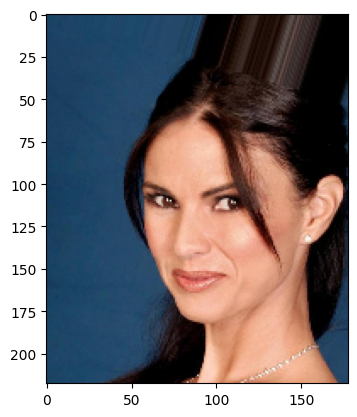

(5000, 224, 224, 3)


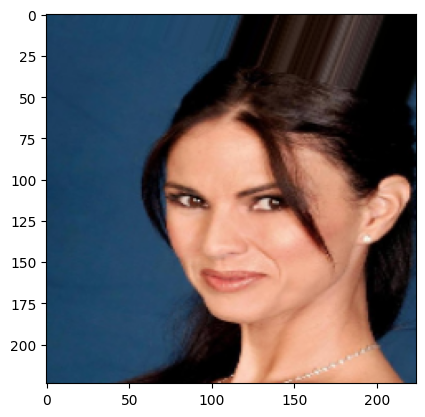

In [4]:
train_tensor = np.zeros((5000,) + (224,224) + (3,), dtype=np.uint8)
X_train = np.array(x_train)
print(X_train.shape)
plt.imshow(X_train[0])
plt.show()

# train_tensor = np.pad(X_train, ((0, 0), (0, 0), (20, 20), (0, 0)), mode='constant', constant_values=0)
for i in range(5000):
    train_tensor[i] = cv2.resize(X_train[i], (224,224))


print(train_tensor.shape)
plt.imshow(train_tensor[0])
plt.show()

(5000, 218, 178, 3)


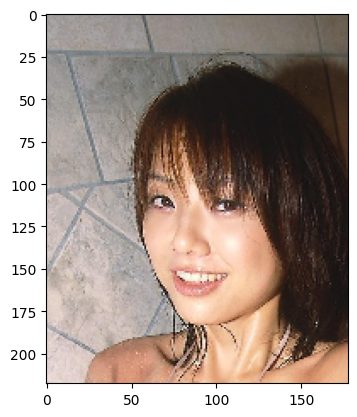

(5000, 224, 224, 3)


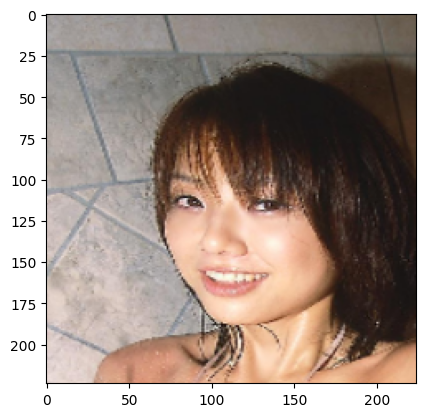

In [5]:
test_tensor = np.zeros((5000,) + (224,224) + (3,), dtype=np.uint8)
X_test = np.array(x_test)
print(X_test.shape)
plt.imshow(X_test[0])
plt.show()
# test_tensor = np.pad(X_test, ((0, 0), (0, 0), (20, 20), (0, 0)), mode='constant', constant_values=0)
for i in range(5000):
    test_tensor[i] = cv2.resize(X_test[i], (224,224))
    
# for i in range(0,5000):
#     test_tensor[i] = test_tensor[i]/255.0

print(test_tensor.shape)
plt.imshow(test_tensor[0])
plt.show()

In [6]:
from keras_vggface.vggface import VGGFace
# Based on RESNET50 architecture -> new paper(2017)                 218, 178, 3
vggface = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg', weights='vggface')

#cv2.resize()

last_layer = vggface.layers[-2].output
x = layers.GlobalAveragePooling2D()(last_layer)

inputs = vggface.inputs
outputs = x
model = Model(inputs, outputs)

model.compile()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                             

In [7]:
# extract a single face from a given photograph
def extract_face(filename, required_size = (224, 224)):
 # load image from file
 pixels = plt.imread(filename)
 # create the detector, using default weights
 detector = mtcnn.MTCNN()
 # detect faces in the image
 results = detector.detect_faces(pixels)
 # extract the bounding box from the first face
 x1, y1, width, height = results[0]['box']
 x2, y2 = x1 + width, y1 + height
 # extract the face
 face = pixels[y1:y2, x1:x2]
 # resize pixels to the model size
 image = Image.fromarray(face)
 image = image.resize(required_size)
 face_array = np.asarray(image)
 return face_array

1/1 [==============================] - 0s 20ms/step


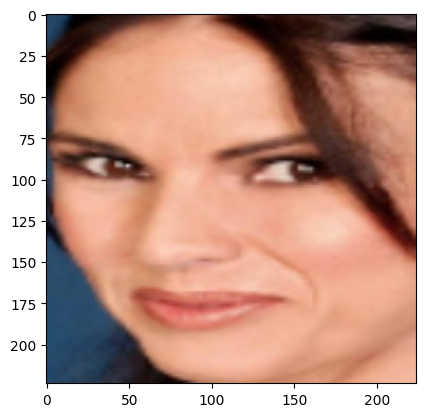

In [8]:
detector = mtcnn.MTCNN()
face_array_train = np.zeros((5000,) + (224,224) + (3,), dtype=np.uint8)
for i in range(0, 5000):
    results = detector.detect_faces(train_tensor[i])
    if results:
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1 + width, y1 + height
        face = train_tensor[i][y1:y2, x1:x2]
        image = np.array(face)
        face_array_train[i] = cv2.resize(image,(224, 224))
        del results, x1, y1, x2, y2, width, height, face, image
    else:
        face_array_train[i] = train_tensor[i]
plt.imshow(face_array_train[0])
plt.show()


1/1 [==============================] - 0s 28ms/step


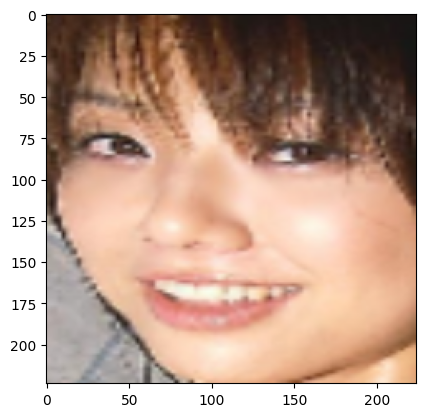

In [9]:
face_array_test = np.zeros((5000,) + (224,224) + (3,), dtype=np.uint8)
for i in range(0, 5000):
    results = detector.detect_faces(test_tensor[i])
    if results:
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1 + width, y1 + height
        face = test_tensor[i][y1:y2, x1:x2]
        image = np.array(face)
        face_array_test[i] = cv2.resize(image,(224, 224))
        del results, x1, y1, x2, y2, width, height, face, image
    else:
        face_array_test[i] = test_tensor[i]
plt.imshow(face_array_test[0])
plt.show()

In [11]:
face_array_test.shape

(5000, 224, 224, 3)

In [12]:
features_train = model.predict(face_array_train)
features_train.shape

157/157 [==============================] - 31s 51ms/step


(5000, 2048)

In [13]:
svm = SVC()
svm.fit(features_train, y_train)
print("Done Training")
#del features_train

features_test = model.predict(face_array_test)
print("Done Building X_test")
accuracy = svm.score(features_test, y_test)
print("Done testing")

Done Training
157/157 [==============================] - 7s 45ms/step
Done Building X_test
Done testing


In [15]:
accuracy

0.9796

In [14]:
predicted_labels = svm.predict(features_test)
cm = confusion_matrix(y_test, predicted_labels)

print(cm)

[[2456   44]
 [  58 2442]]


In [17]:
FPidx = []
FNidx = []
for i in range(0,5000):
    match predicted_labels[i]:
        case 0:
            if y_test[i] == 1:
                FNidx.append(i)
                print(i, " Adicionado em FNEGATIVOS")
            else:
                print(i, "0 - 0")
        case 1:
            if y_test[i] == 0:
                FPidx.append(i)
                print(i, " Adicionado em FPOSITIVOS")
            else:
                print(i, "1 - 1")

0 0 - 0
1 0 - 0
2 0 - 0
3 0 - 0
4 0 - 0
5 0 - 0
6 0 - 0
7 0 - 0
8 0 - 0
9 0 - 0
10 0 - 0
11 0 - 0
12 0 - 0
13 0 - 0
14 0 - 0
15 0 - 0
16 0 - 0
17 0 - 0
18 0 - 0
19 0 - 0
20 0 - 0
21 0 - 0
22 0 - 0
23 0 - 0
24 0 - 0
25 0 - 0
26 0 - 0
27 0 - 0
28 0 - 0
29 0 - 0
30 0 - 0
31 0 - 0
32 0 - 0
33 0 - 0
34 0 - 0
35 0 - 0
36 0 - 0
37 0 - 0
38 0 - 0
39 0 - 0
40 0 - 0
41 0 - 0
42 0 - 0
43 0 - 0
44 0 - 0
45 0 - 0
46 0 - 0
47 0 - 0
48 0 - 0
49 0 - 0
50 0 - 0
51 0 - 0
52 0 - 0
53 0 - 0
54 0 - 0
55 0 - 0
56 0 - 0
57 0 - 0
58 0 - 0
59 0 - 0
60 0 - 0
61 0 - 0
62 0 - 0
63 0 - 0
64 0 - 0
65 0 - 0
66 0 - 0
67 0 - 0
68 0 - 0
69 0 - 0
70 0 - 0
71 0 - 0
72 0 - 0
73 0 - 0
74 0 - 0
75 0 - 0
76 0 - 0
77 0 - 0
78 0 - 0
79 0 - 0
80 0 - 0
81 0 - 0
82 0 - 0
83 0 - 0
84 0 - 0
85 0 - 0
86 0 - 0
87 0 - 0
88 0 - 0
89 0 - 0
90 0 - 0
91 0 - 0
92 0 - 0
93 0 - 0
94 0 - 0
95 0 - 0
96 0 - 0
97 0 - 0
98 0 - 0
99 0 - 0
100 0 - 0
101 0 - 0
102 0 - 0
103 0 - 0
104 0 - 0
105 0 - 0
106 0 - 0
107 0 - 0
108 0 - 0
109 0 - 0
110 0 - 0


In [18]:
print(len(FPidx))
print(len(FNidx))
print(FPidx)

44
58
[154, 176, 180, 246, 424, 470, 486, 490, 639, 719, 754, 807, 812, 819, 839, 863, 868, 993, 1060, 1167, 1233, 1239, 1288, 1498, 1666, 1747, 1815, 1818, 1878, 1884, 1891, 1905, 1950, 2010, 2017, 2039, 2061, 2153, 2174, 2224, 2236, 2250, 2414, 2477]


In [19]:
test_path = "./FACES/train/"
FP_path = "./FACES/False_Positives2/"
FN_path = "./FACES/False_Negatives2/"

if not os.path.exists(FP_path):
        os.makedirs(FP_path)
else:
        shutil.rmtree(FP_path)
        os.makedirs(FP_path)
if not os.path.exists(FN_path):
        os.makedirs(FN_path)
else:
        shutil.rmtree(FN_path)
        os.makedirs(FN_path)

for i in FPidx:
        source_path = os.path.join(test_path, Idx_test[i][:-3]+'png')
        target_path = os.path.join(FP_path, Idx_test[i][:-3]+'png')
        shutil.copy2(source_path, target_path)
for j in FNidx:
        source_path2 = os.path.join(test_path, Idx_test[j][:-3]+'png')
        target_path2 = os.path.join(FN_path, Idx_test[j][:-3]+'png')
        shutil.copy2(source_path2, target_path2)

In [20]:
print("Idx_test = ", len(Idx_test))
print("Idx_test unicos = ", len(np.unique(Idx_test)))

Idx_test =  5000
Idx_test unicos =  5000


# Observações
- O modelo tem uma tendência a classificar mulheres negras como homens, assim como é mostrado na literatura.
- O modelo tem uma tendência a classificar homens que possuem cabelos compridos e lisos como mulheres.
- O modelo possui uma dificuldade de classificar imagens de pessoas que estão usando óculos escuros.
- A MTCNN possui uma difculdade em encontrar faces em imagens em que a pessoa está tampando o rosto com o cabelo, ou está de óculos escuros, ou ambos. Imagens em que não é detectada uma face são passadas para face_array_train e face_array_test completas, sem cropagem (unico tratamento sendo o resize).

# Descobertas
- O dataset CelebA possui erros de rotulação. Imagens de mulheres são classificadas pelo dataset como homens e vice-versa. Isso contamina o resultado, ou seja, mulheres que a rede classifica corretamente estão aparecendo como Falso-Negativos e homens que a rede classifica corretamente estão aparecendo como Falso-Positivos. Isso significa que o nosso conjunto de treinamento também possa estar contaminado, afetando o desempenho da SVM negativamente.
(Ex de erros de rotulação: 009193.jpg, 009918.jpg, 010156.jpg, 006744.jpg e 008497.jpg. Pelo menos mais de 10% dos erros, são imagens que a SVM classificou corretamente, mas que estão rotuladas erradas)

NEXT UP


https://link.springer.com/article/10.1007/s11760-022-02246-8
https://link.springer.com/article/10.1007/s00138-020-01123-z
https://link.springer.com/article/10.1007/s00521-021-06451-3
https://arxiv.org/pdf/2003.08907.pdf

ler esses artigos^^^ e descobrir quais são seus datasets (conseguir se possivel)
